# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

## Introduction

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.29.0

numpy      : 2.1.3
pandas     : 2.2.3
torch      : 2.5.1+cu118
arff2pandas: not installed



In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from scipy.io import arff


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

The goal of this notebook is to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate the model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

The dataset is located in ECG5000.zip

In [ ]:
# Set the device to use for computation (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [26]:
train = arff.loadarff('ECG5000/ECG5000_TRAIN.arff')
df_train = pd.DataFrame(train[0])

test = arff.loadarff('ECG5000/ECG5000_TEST.arff')
df_test = pd.DataFrame(test[0])

print(df_train.shape)
print(df_test.shape)

(500, 141)
(4500, 141)


We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [34]:
df = pd.concat([df_train, df_test], axis=0)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [35]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1577,-1.175840,-0.771456,-2.234445,-4.422567,-4.697272,-4.550699,-3.466229,-2.251740,-1.749851,-0.939631,...,-0.792321,-0.550280,0.317041,0.755046,0.547730,0.482171,-0.324413,0.050543,0.660399,b'1'
2532,1.055882,0.324238,-1.221153,-2.221034,-3.146072,-3.430421,-2.804038,-1.952079,-1.655294,-1.681205,...,0.841028,1.086623,0.748508,0.715252,0.389908,0.249023,0.318490,0.861723,1.355128,b'1'
3464,-0.919906,-1.435172,-1.700165,-1.817940,-2.053490,-2.185987,-2.068212,-1.832662,-1.199622,-0.610747,...,-1.096569,-1.891550,-2.774862,-3.834836,-4.556208,-4.364823,-3.393180,-2.406815,-1.965159,b'2'
1382,0.837342,-1.566331,-3.168719,-4.069600,-4.920173,-4.476308,-2.863320,-1.844990,-1.627832,-0.506373,...,1.138322,1.927484,1.793192,1.964867,1.611894,1.161988,0.205990,-0.487169,0.107766,b'1'
1219,0.243254,-2.559384,-3.294061,-3.500945,-3.045317,-2.368781,-0.994040,-0.303798,-0.019706,0.511722,...,-0.539454,-0.593563,-0.803710,-0.788719,-0.988701,-0.769639,-0.730476,-1.425795,-4.165895,b'1'


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [36]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [37]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [38]:
df.target.value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

Let's plot the results:

C:\Users\pleno\AppData\Local\Temp\ipykernel_31900\1255488451.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(class_names);


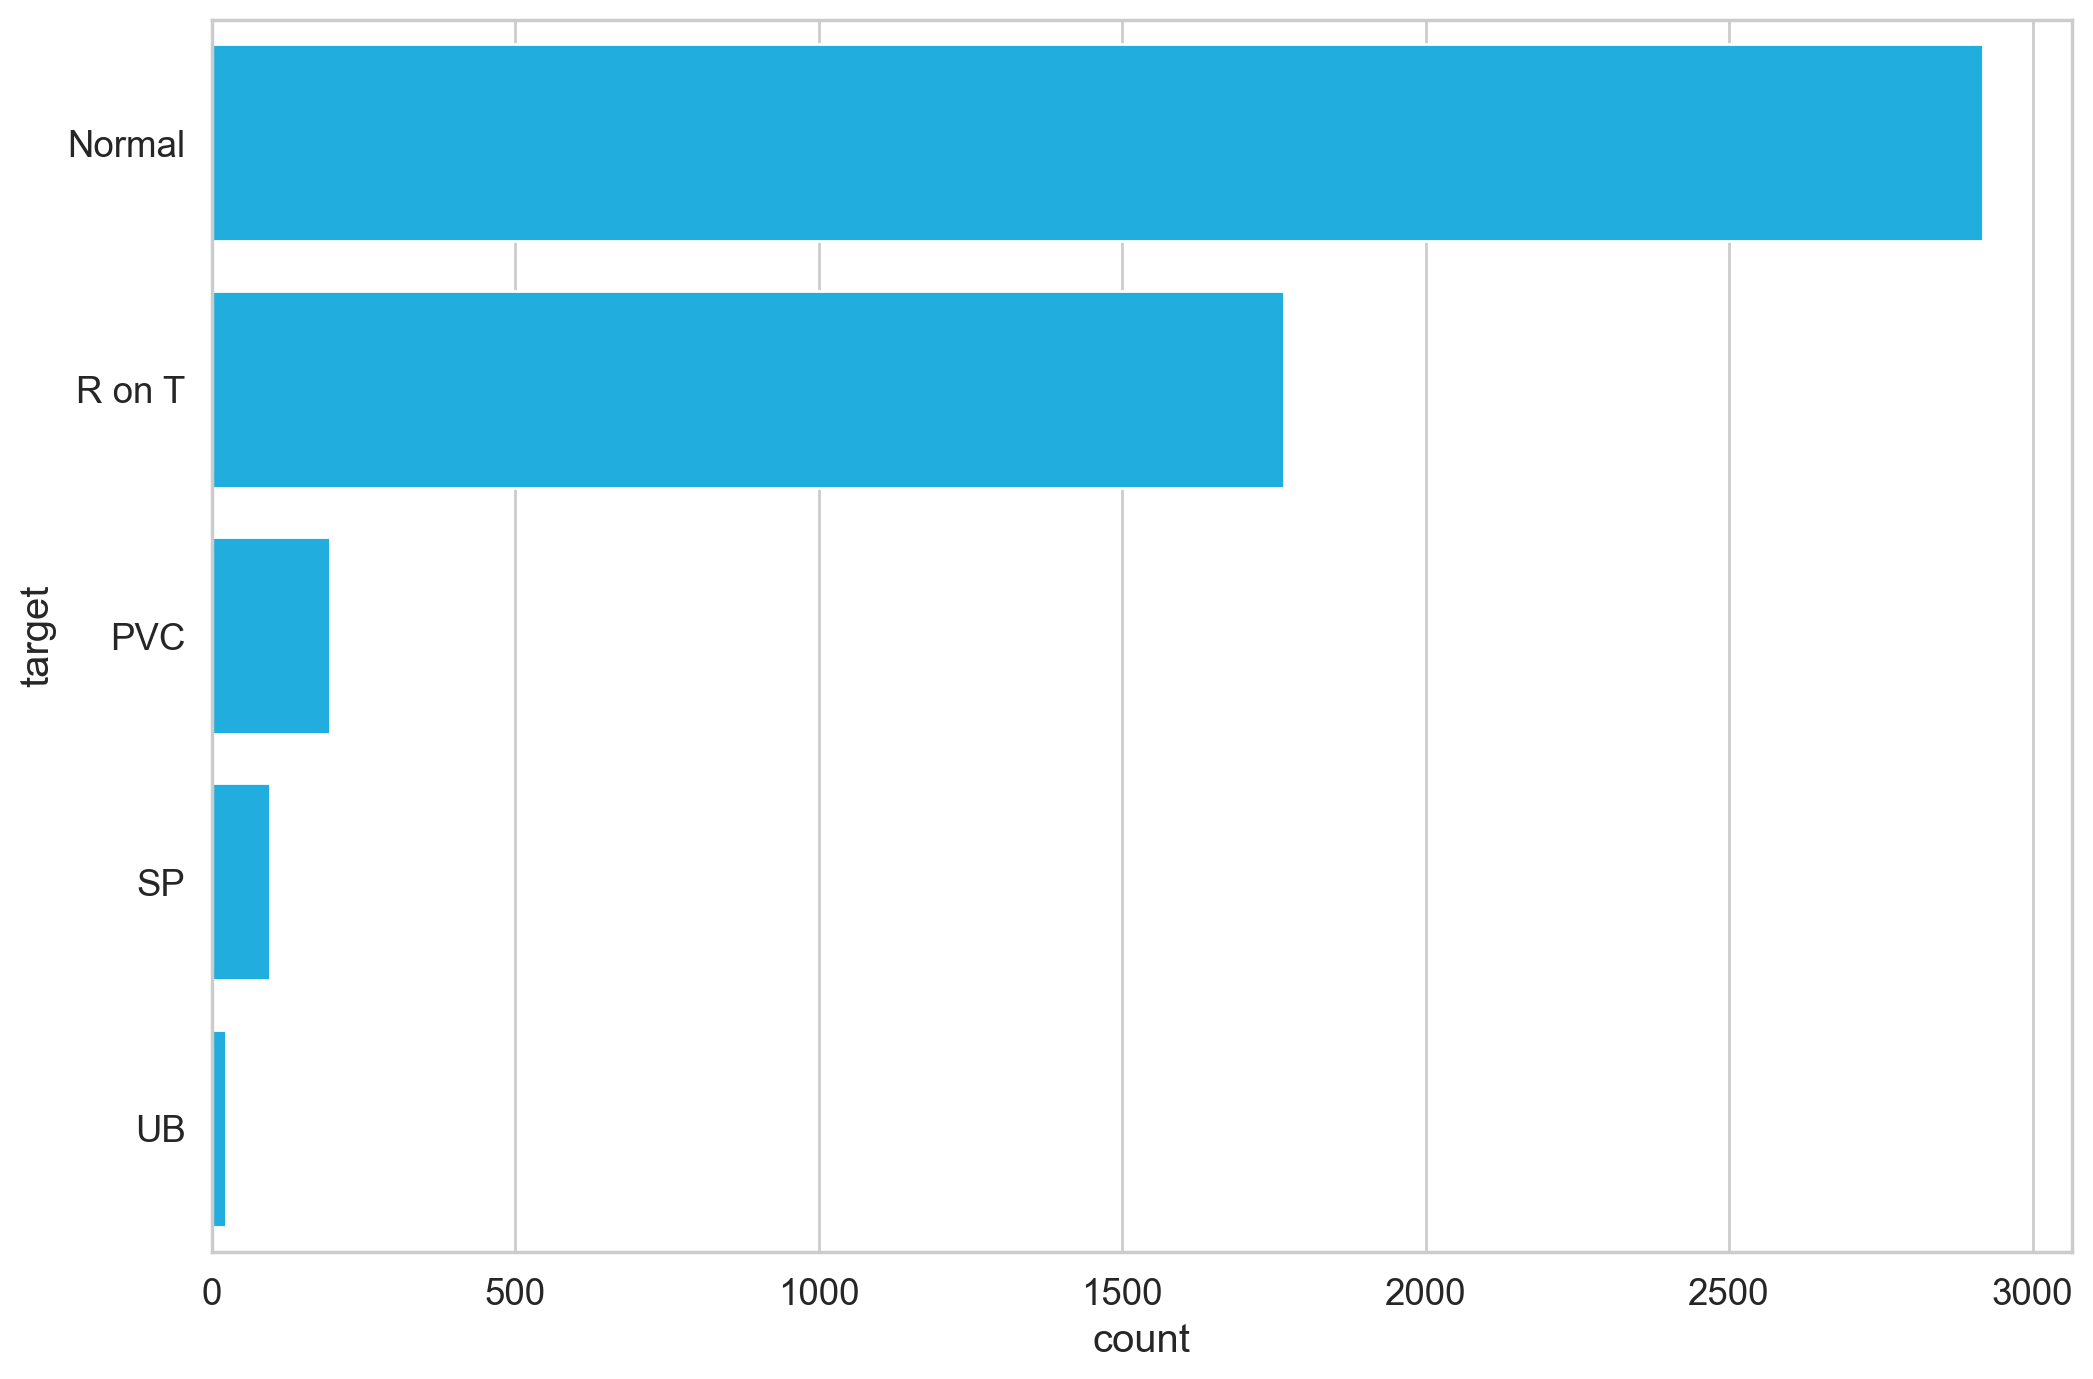

In [40]:
ax = sns.countplot(df.target)
ax.set_yticklabels(class_names);

The normal class has the most examples and we'll use it to train our model.

We can check the averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [41]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

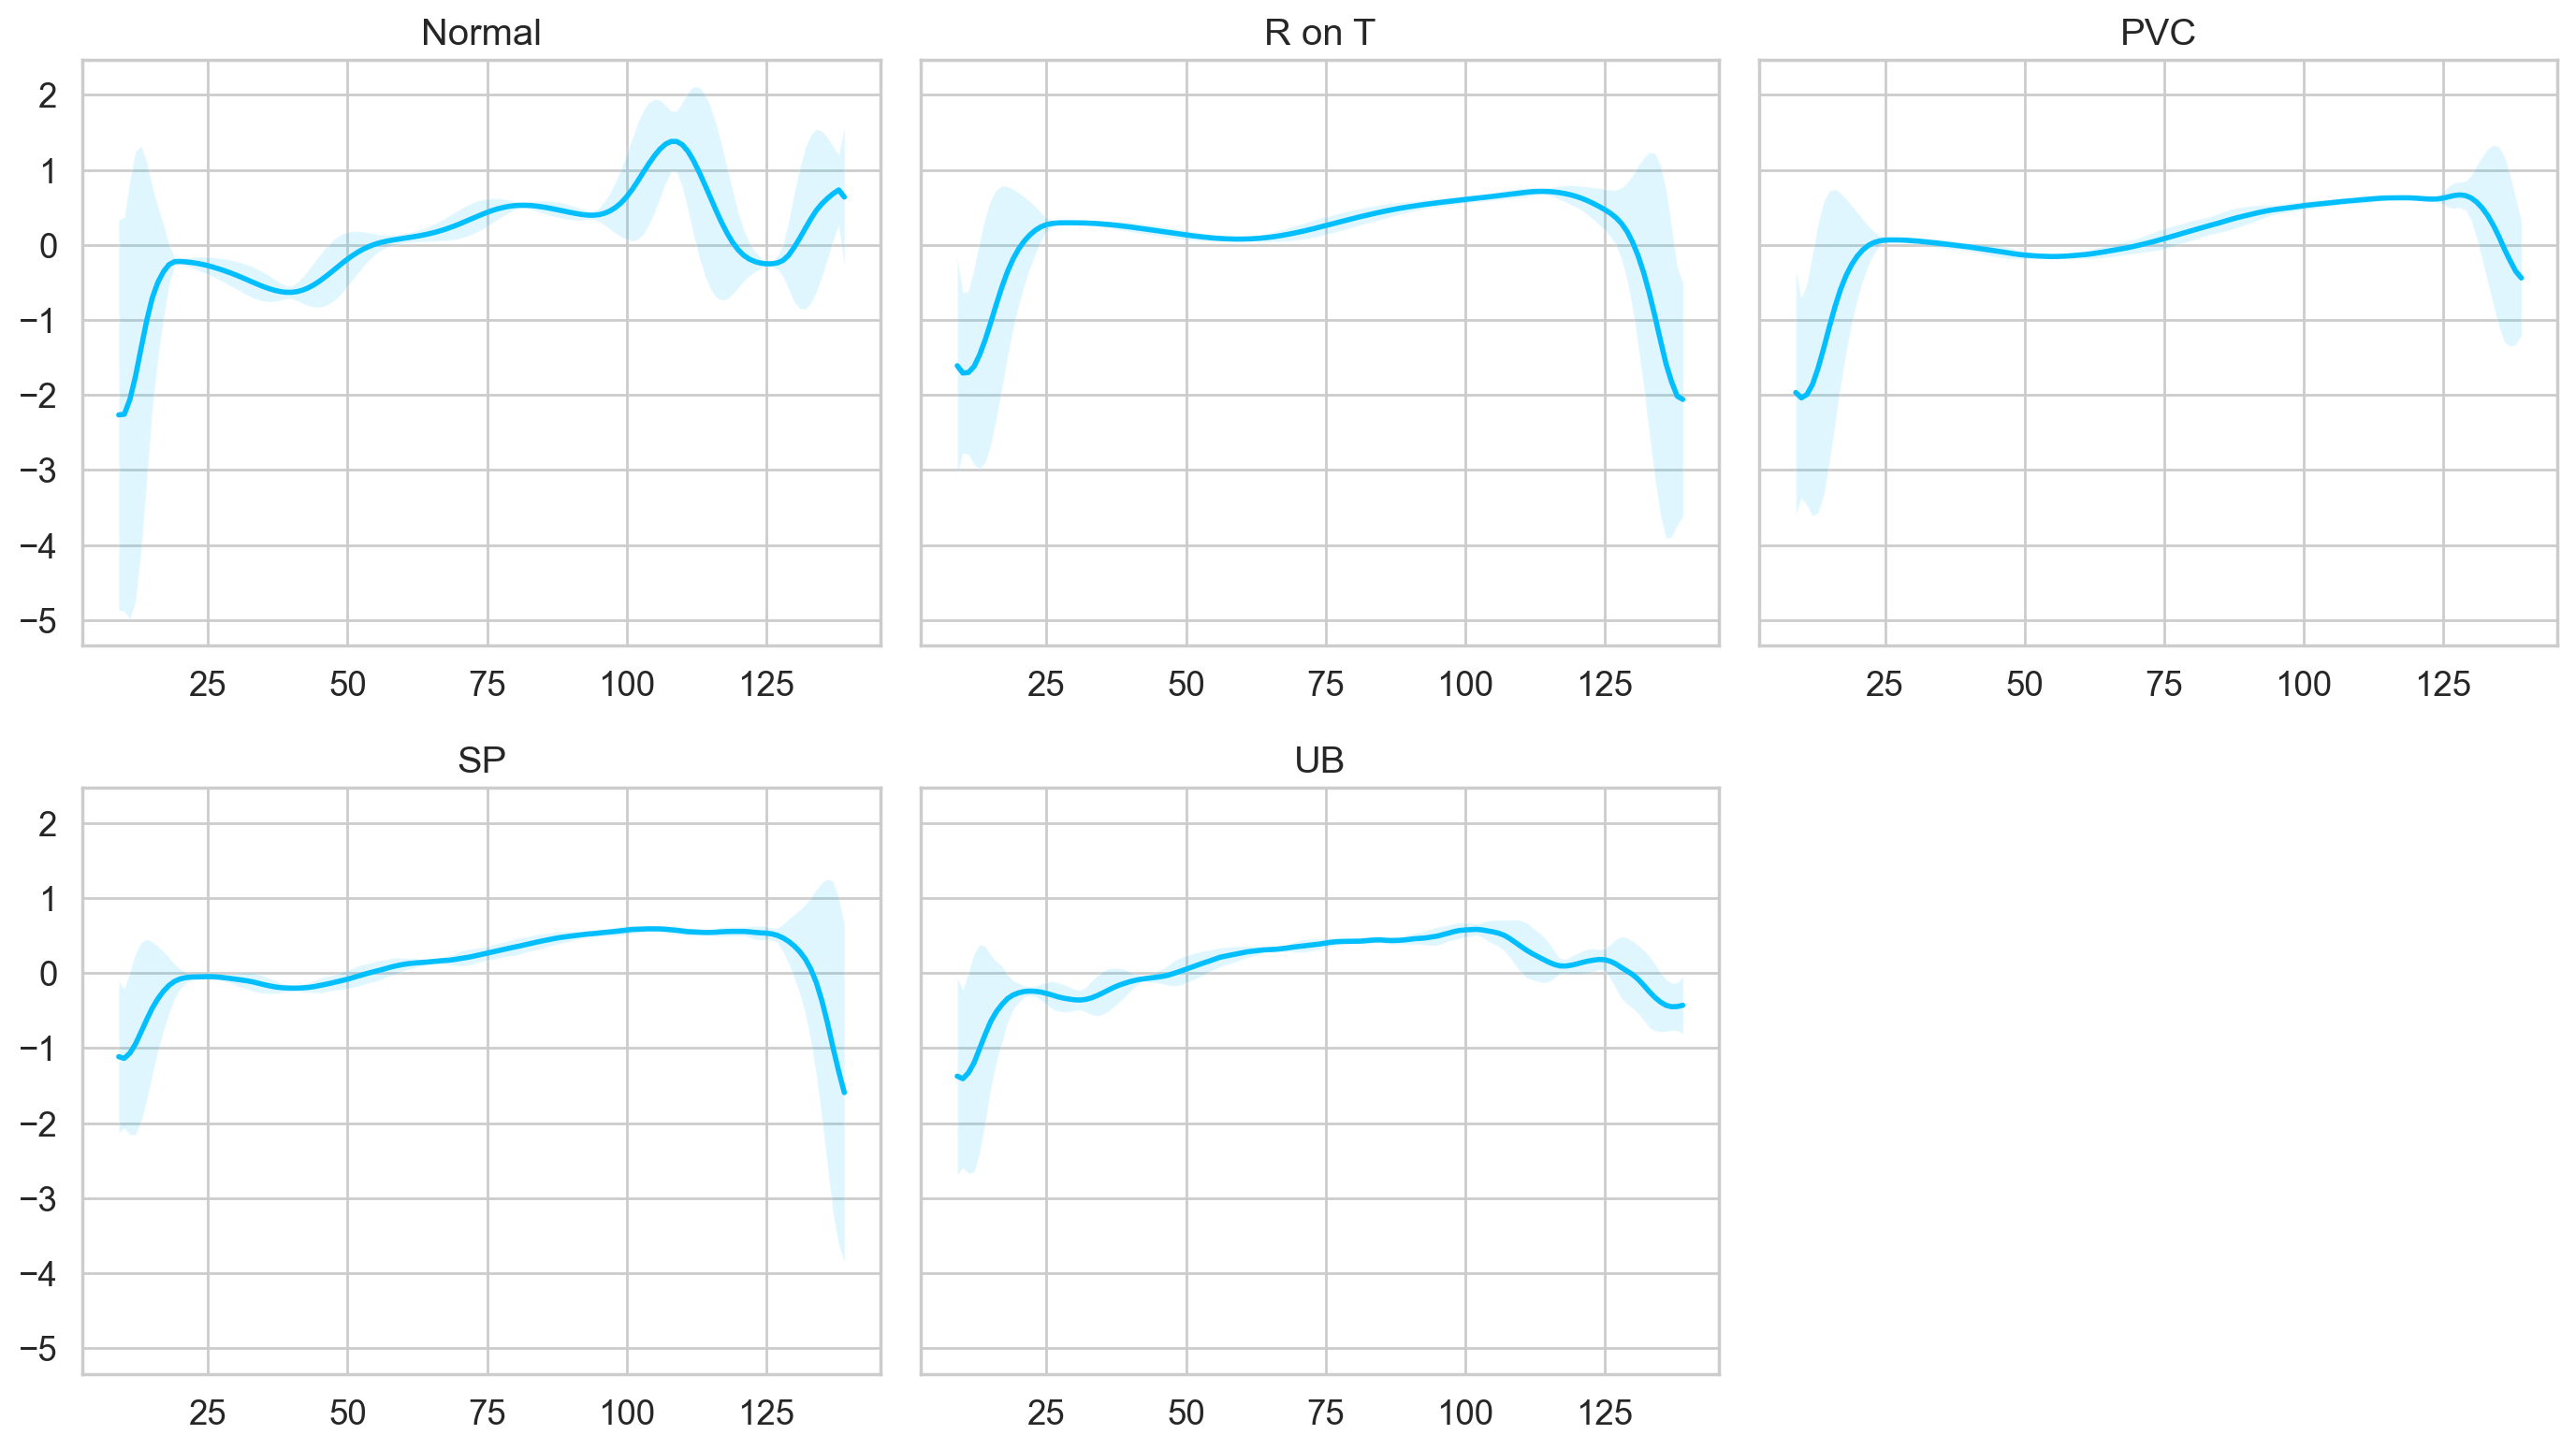

In [42]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

We can observe that the normal class has a clearly different pattern than all other classes.

One can hope this pattern will be usefull to detect anomalies!

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [45]:
normal_df = df[df.target.str.decode('utf-8') == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

We'll merge all other classes and mark them as anomalies:

In [46]:
anomaly_df = df[df.target.str.decode('utf-8') != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

We'll split the normal examples into train, validation and test sets:

In [47]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [48]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [50]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

In [55]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [56]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Now we create the whole model containing the *Encoder* and *Decoder*

In [57]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Let's create an instance of it:

In [58]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

In [59]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [60]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 66.71424894321353 val loss 59.06540448185527
Epoch 2: train loss 54.07239851822828 val loss 54.94496415174048
Epoch 3: train loss 51.86219327173998 val loss 53.00403443945146
Epoch 4: train loss 51.13927044420654 val loss 52.38439964190278
Epoch 5: train loss 43.25195618975023 val loss 34.790461087796466
Epoch 6: train loss 30.609540613367404 val loss 28.03582341190898
Epoch 7: train loss 27.596846019678758 val loss 25.888892922385153
Epoch 8: train loss 26.842681200549467 val loss 25.479308242277074
Epoch 9: train loss 24.68659771608278 val loss 22.77637773650498
Epoch 10: train loss 23.427411563739522 val loss 21.448577708351735
Epoch 11: train loss 21.08589258236253 val loss 20.636097383987373
Epoch 12: train loss 20.2780901248875 val loss 19.13811768606661
Epoch 13: train loss 19.387955979635908 val loss 18.992014246995947
Epoch 14: train loss 18.30570406070019 val loss 19.041378961895106
Epoch 15: train loss 17.639533230298376 val loss 17.441713456814607
Epoch 

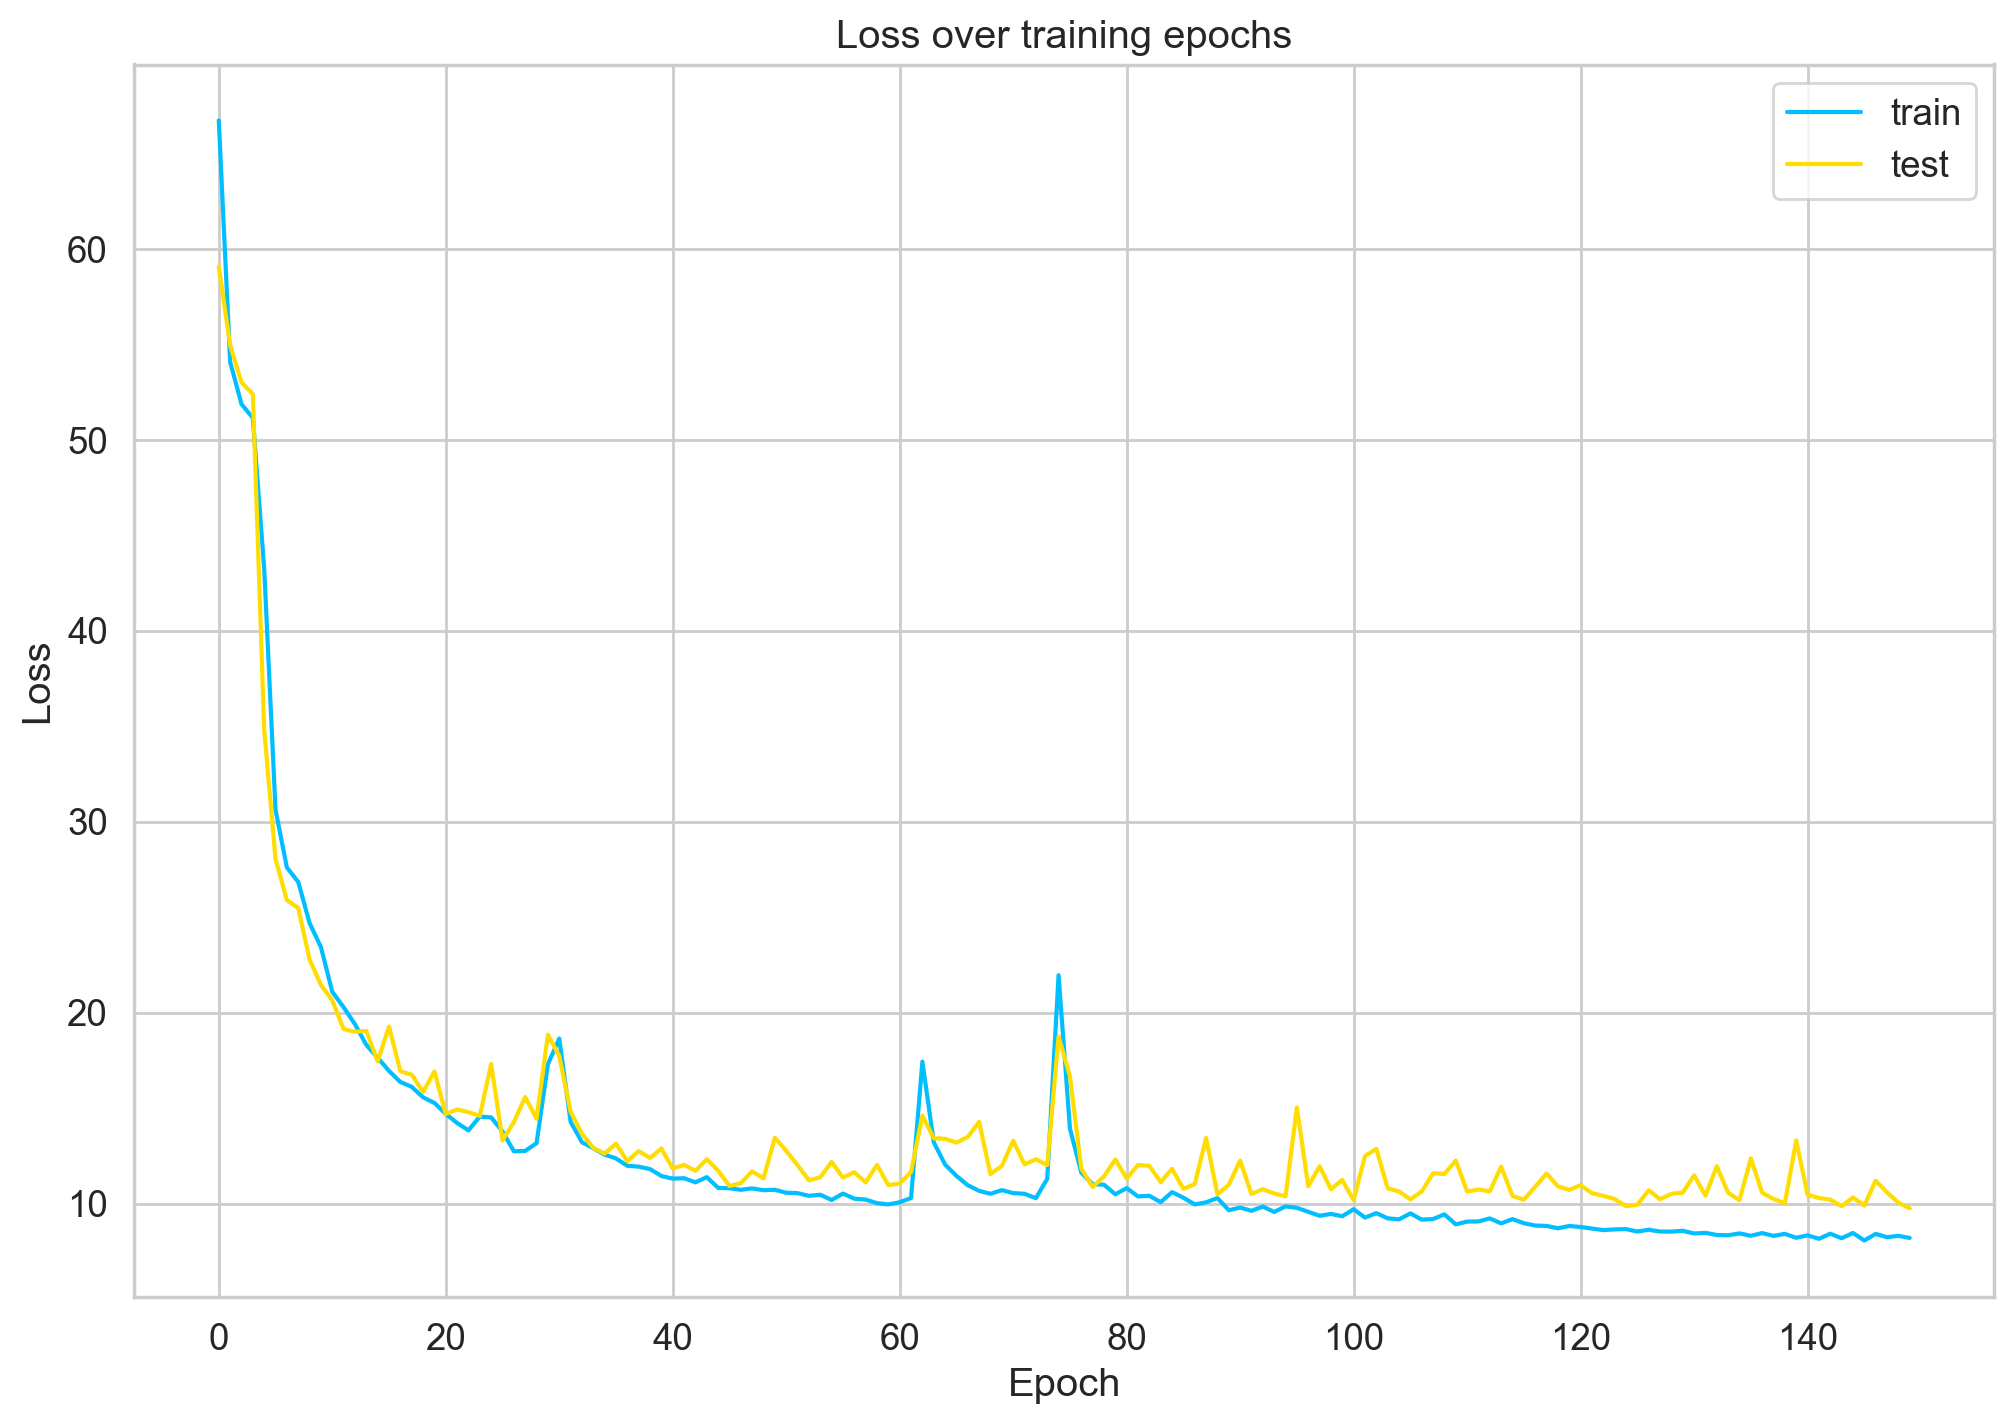

In [61]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Saving the model

Let's store the model for later use:

In [62]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [0]:
# model = torch.load('pretrained_model.pth')
# model = model.to(device)

## Choosing a threshold

We can now look at the reconstruction error on the training set.

In [63]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

C:\Users\pleno\AppData\Local\Temp\ipykernel_31900\1153265548.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


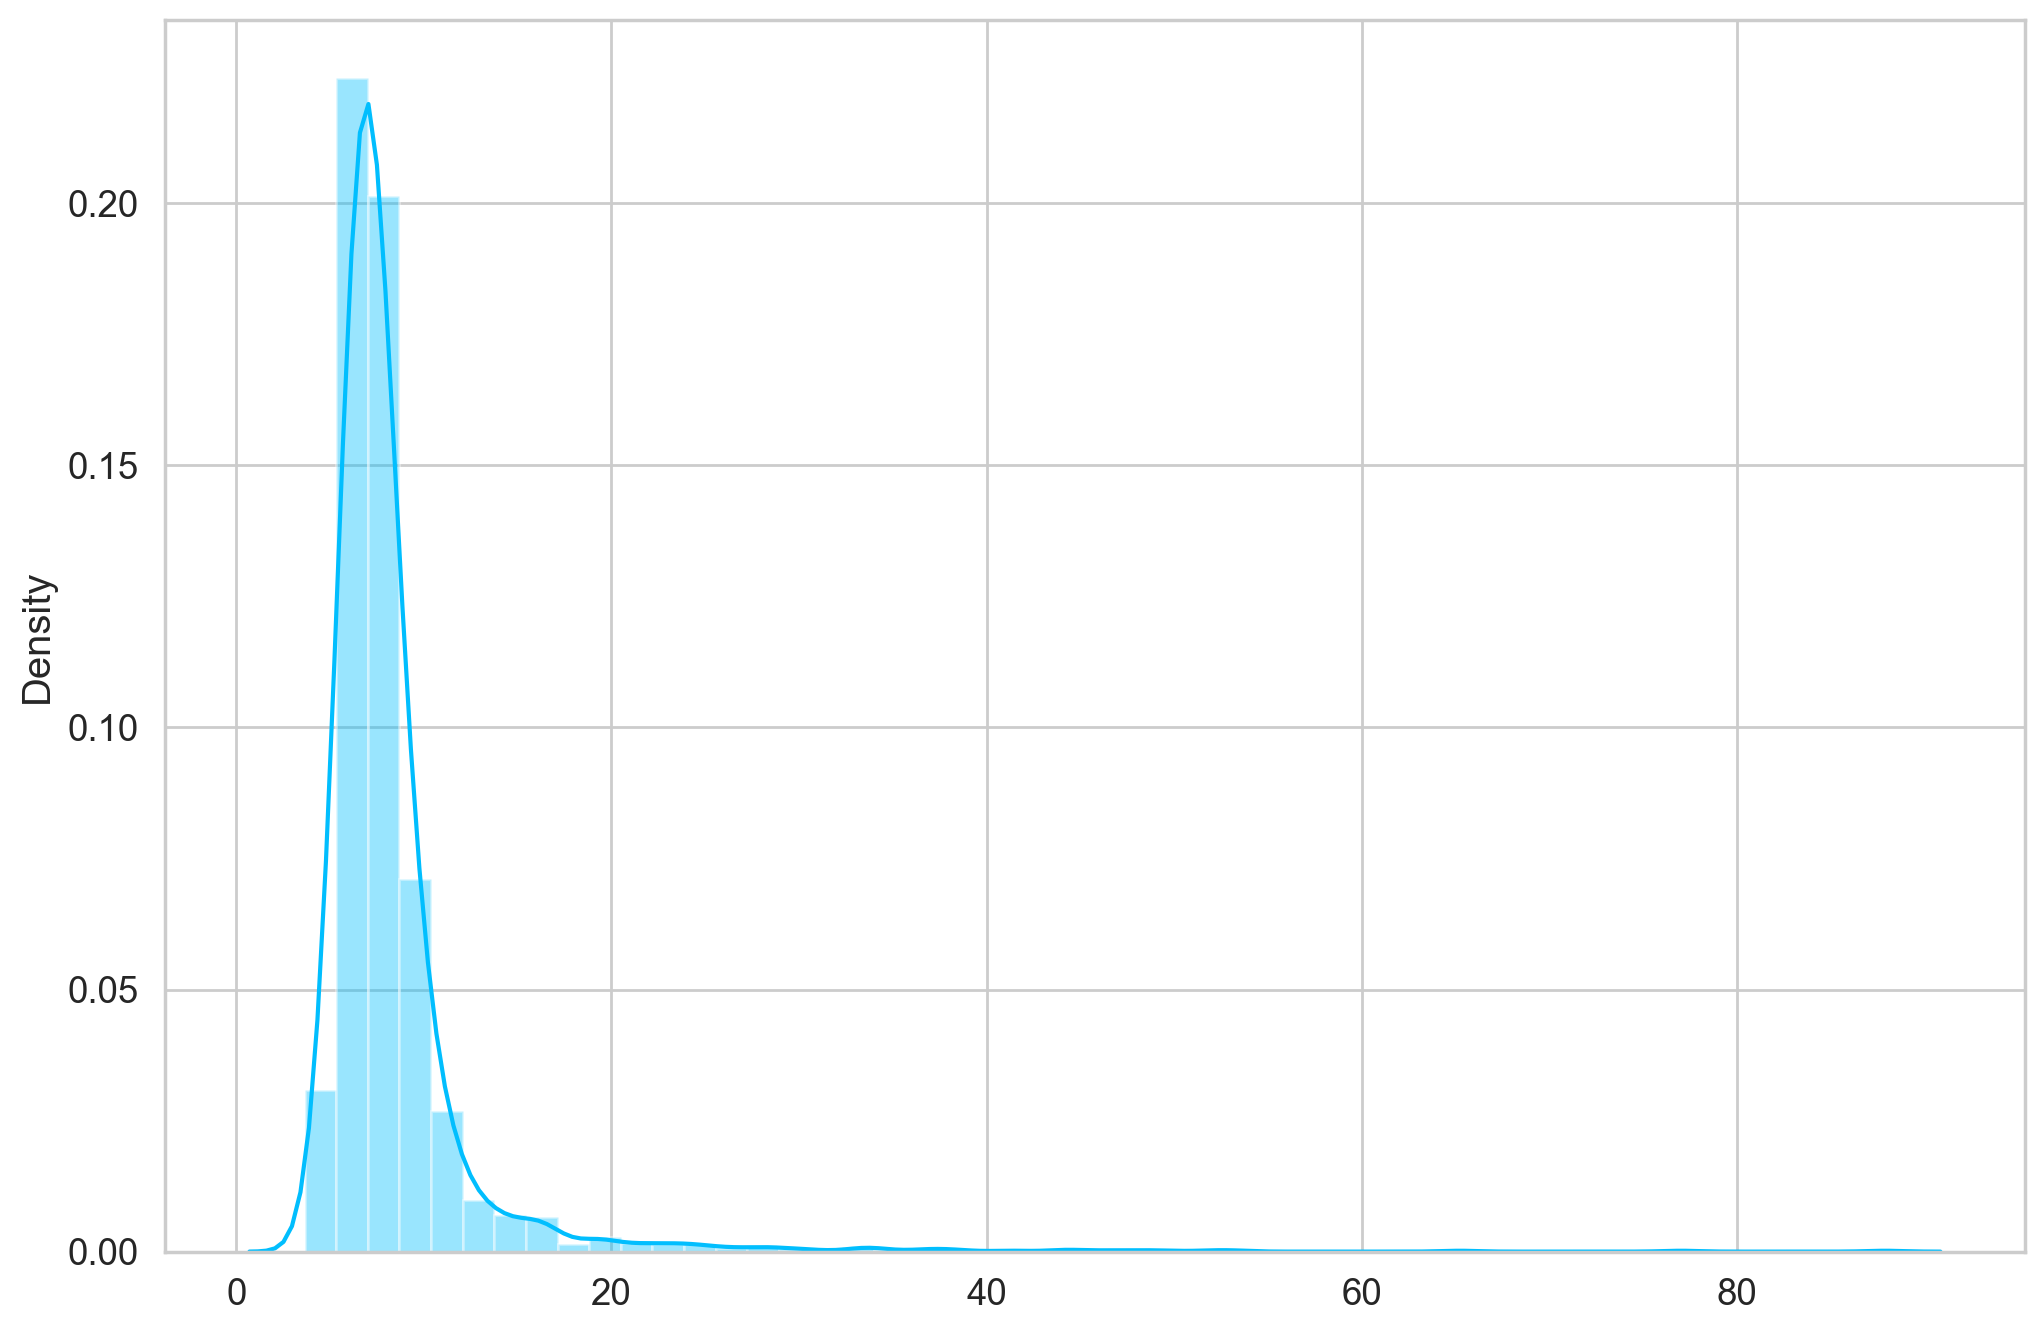

In [64]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
# Manually selected threshold
THRESHOLD = 30

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats using normal heartbeats from the test set:

C:\Users\pleno\AppData\Local\Temp\ipykernel_31900\3242963548.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


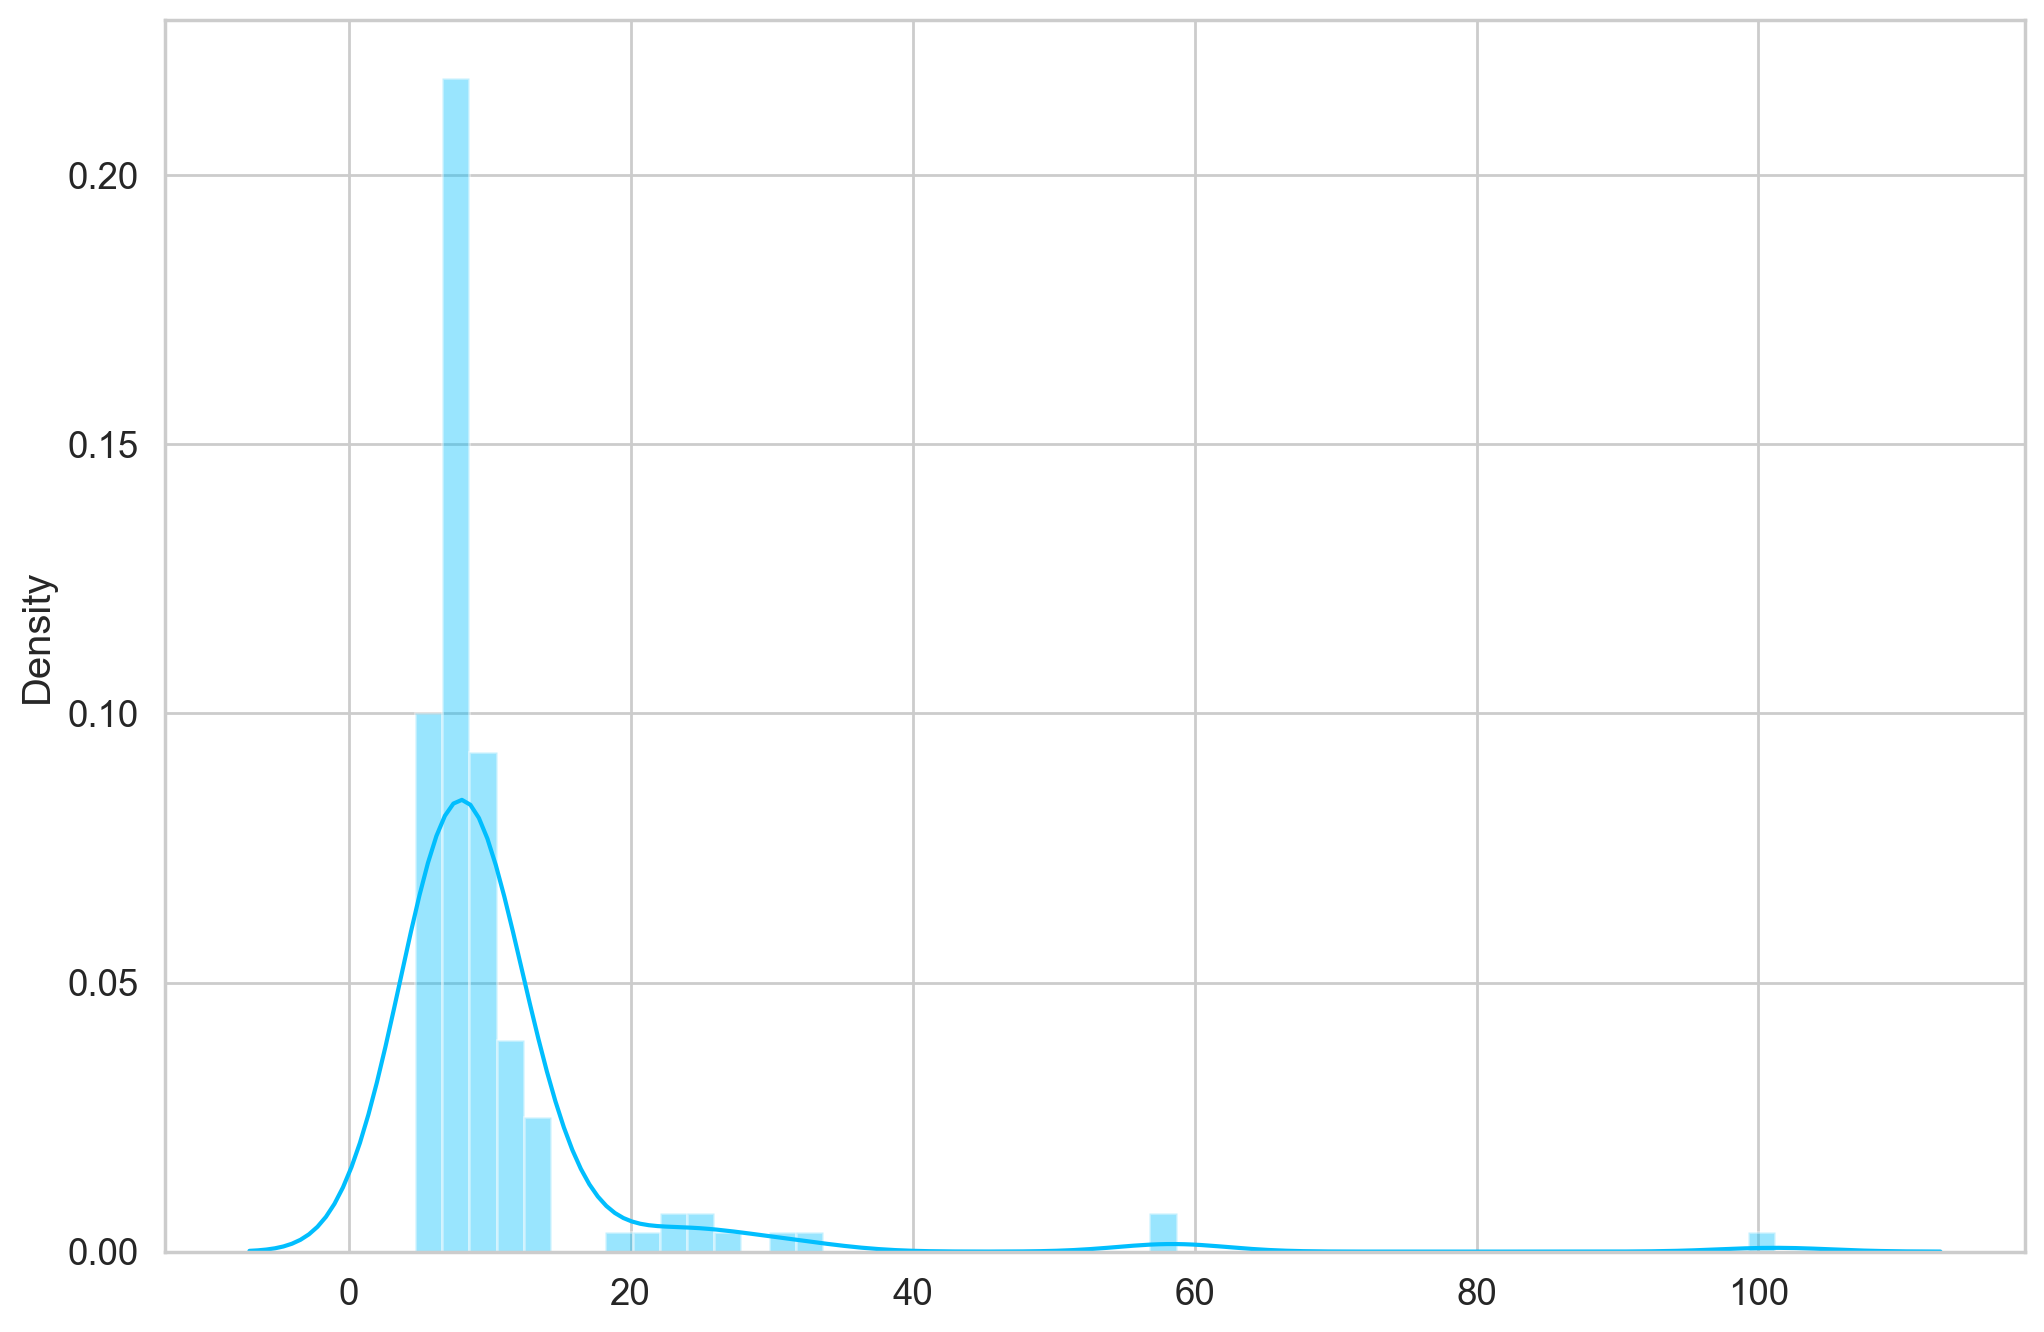

In [80]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [85]:
correct = sum(l <= THRESHOLD for l in pred_losses)
percent = round(correct/len(test_normal_dataset)*100, 2)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)} - Accuracy: {percent}%')

Correct normal predictions: 140/145 - Accuracy: 96.55%


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [73]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

C:\Users\pleno\AppData\Local\Temp\ipykernel_31900\2222098121.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


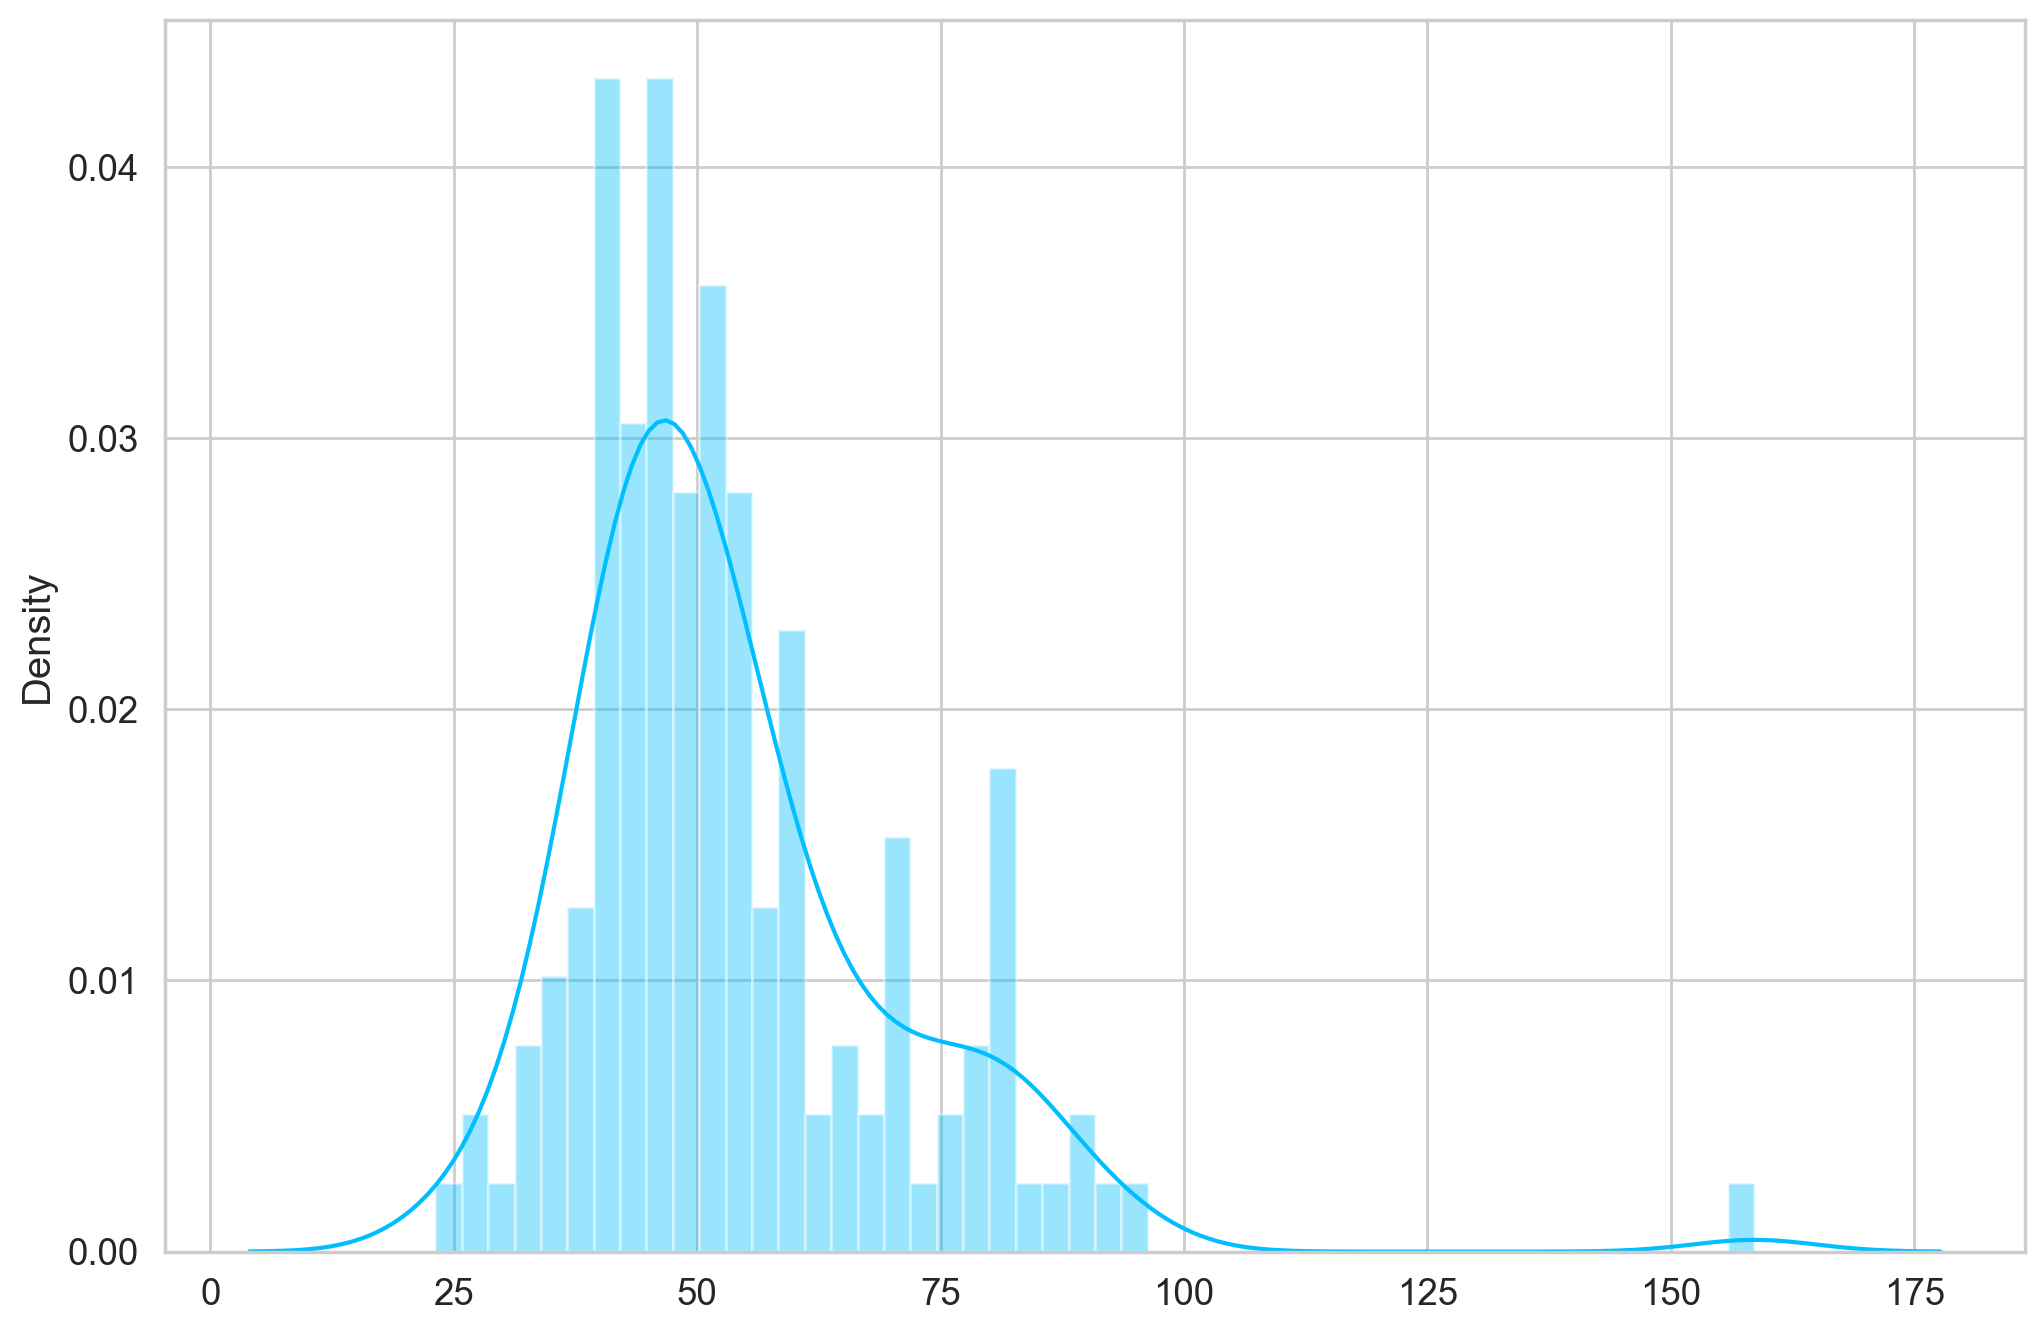

In [87]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [88]:
correct = sum(l > THRESHOLD for l in pred_losses)
percent = round(correct/len(anomaly_dataset)*100, 2)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)} - Accuracy: {percent}%')

Correct anomaly predictions: 142/145 - Accuracy: 97.93%


#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are.

In [76]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

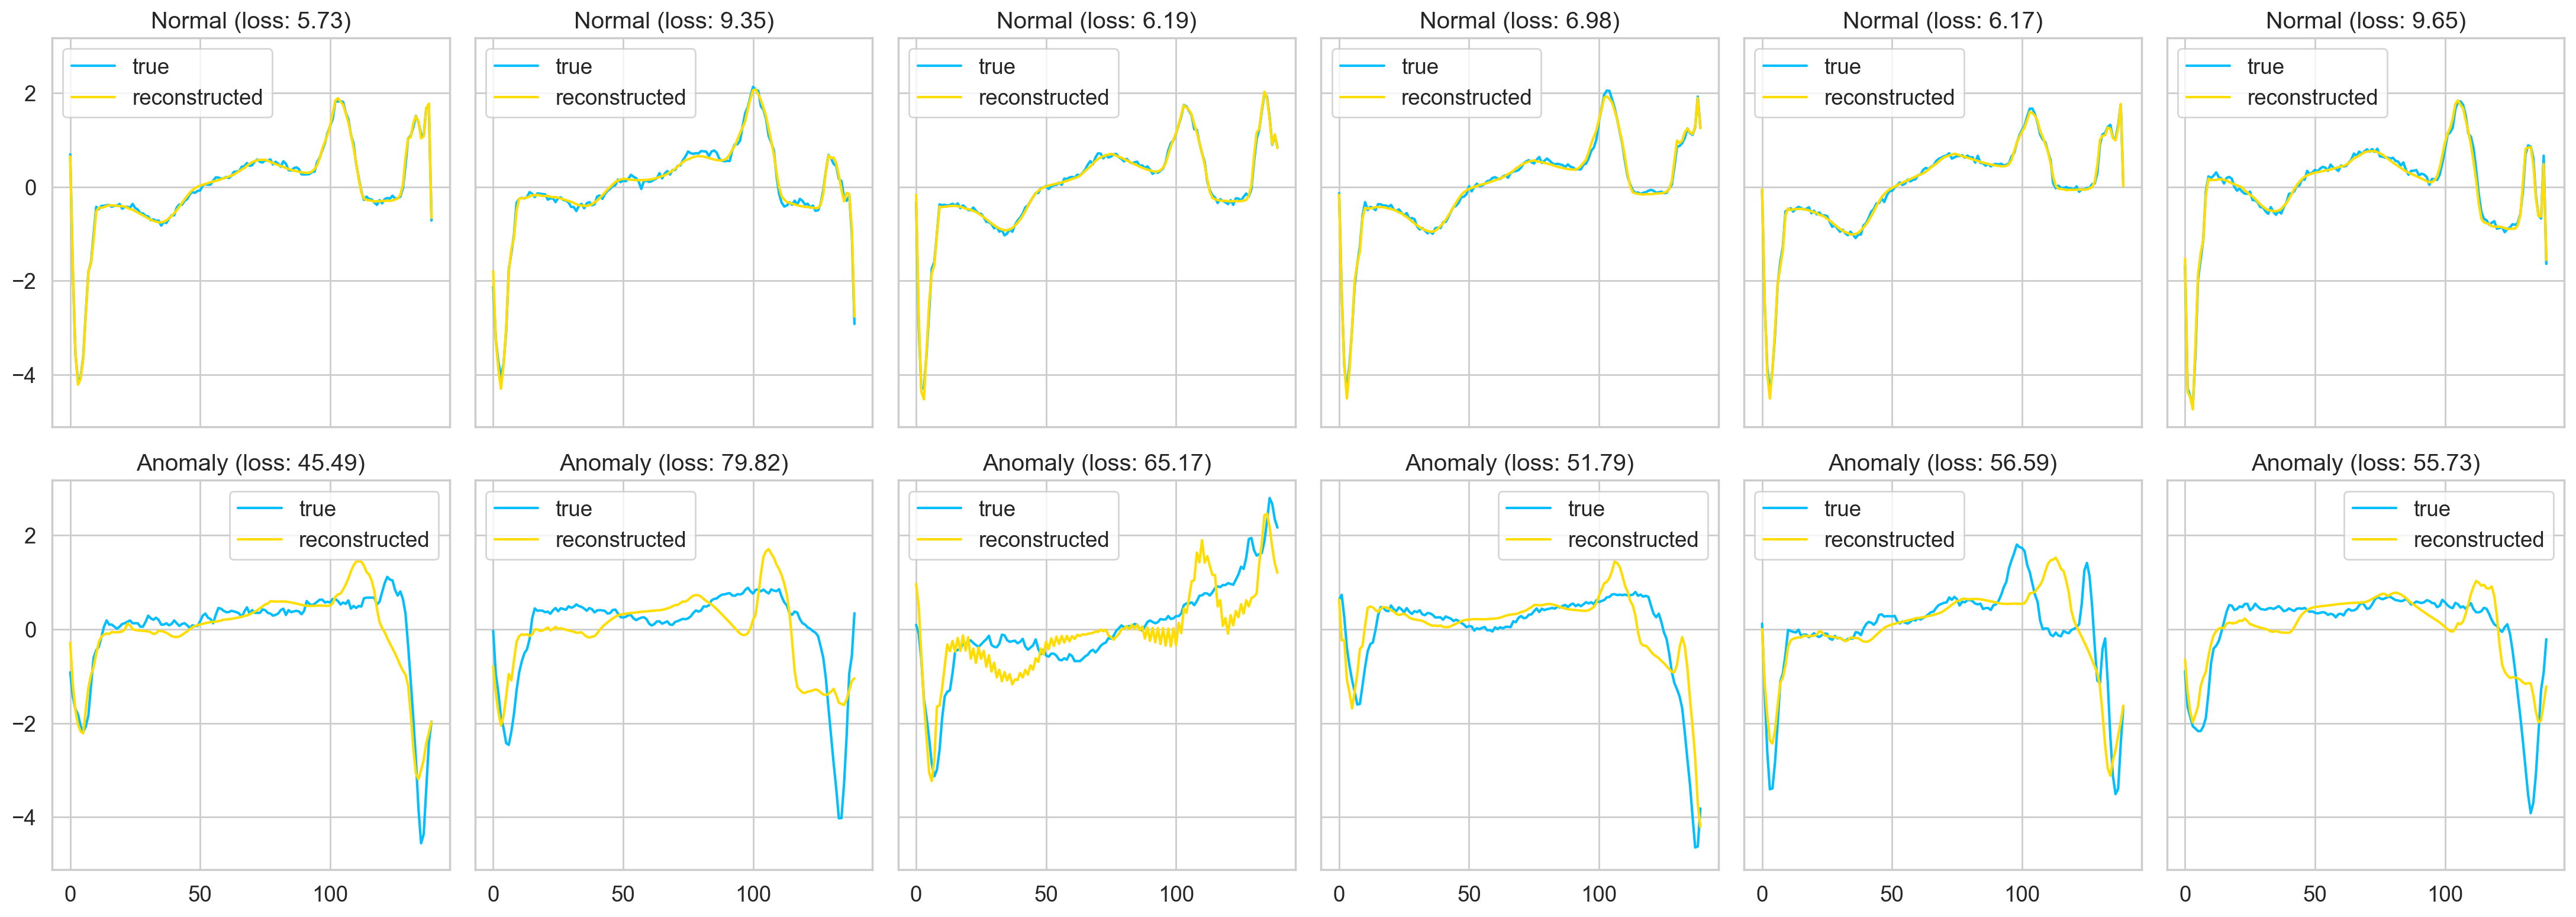

In [77]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)